In [5]:
import csv
import matplotlib.pyplot as plt
from scikitplot.plotters import plot_pca_component_variance

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from sklearn.cluster import KMeans
from sklearn.metrics import plot_confusion_matrix

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import Binarizer
from sklearn.tree import DecisionTreeClassifier, export_text

xformbin = Binarizer(1.5)
xformbin.transform(np.array([[0, 7],[3, 2], [12, -3]]))

C:\Users\christo\anaconda3\envs\datascience39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=1.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([[0, 1],
       [1, 1],
       [1, 0]])

In [6]:
# https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html#:~:text=The%20full%20GEOID%20for%20many,codes%2C%20in%20which%20they%20nest.
counties = pd.read_csv('data/2020_Gaz_tracts_national.txt', delimiter='\t', dtype={'GEOID': str}).reindex()
counties.columns = [c.strip() for c in counties.columns.to_list()]
counties['FIPS_COUNTY'] = counties['GEOID'].apply(lambda x: x[:5])
counties = counties[['FIPS_COUNTY', 'GEOID', 'INTPTLAT', 'INTPTLONG']].reindex()
counties.FIPS_COUNTY.unique()
counties = counties.drop(columns=['GEOID']).groupby('FIPS_COUNTY').agg('mean').reset_index()

In [7]:
all_food = pd.read_csv('data/census_december_2019-food-security.csv', encoding='ISO-8859-1',
                   dtype={'GTCBSAST': np.str, 'GTMETSTA': np.str, 'GTINDVPC': np.str, 'GCFIP': np.str, 'GCTCO': np.str,
                          'GCTCB': np.str})
food = all_food.loc[:]
food.columns.to_list()


def find_col(s):
    return list(filter(lambda x: s.lower() in x.lower(), food.columns))


find_col('hrint')
print(f"columns: {food.columns.to_list()}\ncount: {food.size}")

<ipython-input-7-64a3981b0334>:2: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype={'GTCBSAST': np.str, 'GTMETSTA': np.str, 'GTINDVPC': np.str, 'GCFIP': np.str, 'GCTCO': np.str,
<ipython-input-7-64a3981b0334>:3: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'GCTCB': np.str})


columns: ['HRHHID', 'HRMONTH', 'HRYEAR4', 'HURESPLI', 'HUFINAL', 'HULANGCODE', 'HETENURE', 'HEHOUSUT', 'HETELHHD', 'HETELAVL', 'HEPHONEO', 'HEFAMINC', 'HUTYPEA', 'HUTYPB', 'HUTYPC', 'HWHHWGT', 'HRINTSTA', 'HRNUMHOU', 'HRHTYPE', 'HRMIS', 'HUINTTYP', 'HUPRSCNT', 'HRLONGLK', 'HRHHID2', 'HWHHWTLN', 'FILLER', 'HUBUS', 'HUBUSL1', 'HUBUSL2', 'HUBUSL3', 'HUBUSL4', 'GEREG', 'GEDIV', 'GCFIP', 'GCTCB', 'GCTCO', 'GTCBSAST', 'GTMETSTA', 'GTINDVPC', 'GTCBSASZ', 'GCTCS', 'PERRP', 'PEPARENT', 'PRTAGE', 'PRTFAGE', 'PEMARITL', 'PESPOUSE', 'PESEX', 'PEAFEVER', 'PEAFNOW', 'PEEDUCA', 'PTDTRACE', 'PRDTHSP', 'PUCHINHH', 'PULINENO', 'PRFAMNUM', 'PRFAMREL', 'PRFAMTYP', 'PEHSPNON', 'PRMARSTA', 'PRPERTYP', 'PENATVTY', 'PEMNTVTY', 'PEFNTVTY', 'PRCITSHP', 'PRCITFLG', 'PRINUYER', 'PUSLFPRX', 'PEMLR', 'PUWK', 'PUBUS1', 'PUBUS2OT', 'PUBUSCK1', 'PUBUSCK2', 'PUBUSCK3', 'PUBUSCK4', 'PURETOT', 'PUDIS', 'PERET1', 'PUDIS1', 'PUDIS2', 'PUABSOT', 'PULAY', 'PEABSRSN', 'PEABSPDO', 'PEMJOT', 'PEMJNUM', 'PEHRUSL1', 'PEHRUSL2', '

In [8]:
all_food.describe()
all_food.head()

,HRHHID,HRMONTH,HRYEAR4,HURESPLI,HUFINAL,HULANGCODE,HETENURE,HEHOUSUT,HETELHHD,HETELAVL,...,HRFS30D1,HRFS30D2,HRFS30D3,HRFS30D4,HRFS30D5,HRFS30D6,HRFS30D7,HRFS30D8,HRFS30D9,HRFS30DE
0,581125017600866,12,2019,2,201,0,1,1,1,-1,...,1,1,0,-6,1,0,-6,1,0,-6
1,581125017600866,12,2019,2,201,0,1,1,1,-1,...,1,1,0,-6,1,0,-6,1,0,-6
2,581125017600866,12,2019,2,201,0,1,1,1,-1,...,1,1,0,-6,1,0,-6,1,0,-6
3,581125017600866,12,2019,2,201,0,1,1,1,-1,...,1,1,0,-6,1,0,-6,1,0,-6
4,809001585510960,12,2019,1,201,0,2,1,1,-1,...,1,1,0,-6,1,0,-6,1,0,-6


In [9]:
all_food.isna().count()

HRHHID      138964
HRMONTH     138964
HRYEAR4     138964
HURESPLI    138964
HUFINAL     138964
             ...  
HRFS30D6    138964
HRFS30D7    138964
HRFS30D8    138964
HRFS30D9    138964
HRFS30DE    138964
Length: 510, dtype: int64

In [10]:
# len(all_food.columns[all_food.dtypes != 'object'])
# Percent of features which are 'not helpful'
all_food[all_food[all_food.columns[all_food.dtypes != 'object']] < 0].count().sum() / all_food.size

0.6660616714951143

In [11]:
len(all_food)

138964

In [12]:
food = food[food['HRINTSTA'] == 1]  # get rid of non-interview results
food = food.drop(columns=find_col('px'))  # drop 'allocation flag' columns
food.size

48352120

### HRFS12M1
indicates total household food security status
values:
- 1: secure
- 2: Low security
- 3: very low security
- -9: no response

### HRFS12MC
indicates food security status of children in the household
values:
- 1: children are food secure
- 2: low child food security
- 3: very low child food security
- -9: no response

### HRFS12M8
indicates food security status of adults in the household
values:
- 1: adults are food secure
- 2: low adult food security
- 3: very low adult food security
- -9: no response

In [13]:
geo_cols = ['GCFIP', 'GCTCO', 'FIPS_COUNTY']  # GCTCB is mislabeled in the doc as GCTCBSA
food_cols = ['HRFS12M1', 'HRFS12MC', 'HRFS12M8']
id_cols = ['QSTNUM']

# throw out records with no county code
food = food[food.GCTCO != '000']
food['FIPS_COUNTY'] = food.GCFIP + food.GCTCO

food.groupby(['FIPS_COUNTY']).agg('count')

,HRHHID,HRMONTH,HRYEAR4,HURESPLI,HUFINAL,HULANGCODE,HETENURE,HEHOUSUT,HETELHHD,HETELAVL,...,HRFS30D1,HRFS30D2,HRFS30D3,HRFS30D4,HRFS30D5,HRFS30D6,HRFS30D7,HRFS30D8,HRFS30D9,HRFS30DE
FIPS_COUNTY,,,,,,,,,,,,,,,,,,,,,
01003,165,165,165,165,165,165,165,165,165,165,...,165,165,165,165,165,165,165,165,165,165
01081,134,134,134,134,134,134,134,134,134,134,...,134,134,134,134,134,134,134,134,134,134
01097,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
04013,1231,1231,1231,1231,1231,1231,1231,1231,1231,1231,...,1231,1231,1231,1231,1231,1231,1231,1231,1231,1231
04019,280,280,280,280,280,280,280,280,280,280,...,280,280,280,280,280,280,280,280,280,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55059,43,43,43,43,43,43,43,43,43,43,...,43,43,43,43,43,43,43,43,43,43
55073,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,36,36,36,36,36
55101,80,80,80,80,80,80,80,80,80,80,...,80,80,80,80,80,80,80,80,80,80


In [14]:
y = food['HRFS12M1'].fillna(0).clip(lower=0)

In [15]:
supp_cols = find_col('HES')
X = food.loc[:][supp_cols]
for c in supp_cols:
    X[c] = X[c].fillna(0)
    X[c] = X[c].clip(lower=0)
X.iloc[18:23].clip(lower=0)

,HES1A,HES1B,HES1C,HES1D,HES8B,HES9,HESP1,HESP21,HESP22,HESP23,...,HESSH5,HESC1,HESC2,HESC3,HESCF3,HESCM3,HESC3A,HESC4,HESCF4,HESCM4
40,1,1,2,1,2,1,2,0,0,0,...,0,0,0,2,0,0,0,2,0,0
41,1,1,1,2,3,2,2,0,0,0,...,0,0,0,2,0,0,1,2,0,0
42,1,1,1,2,3,2,2,0,0,0,...,0,0,0,2,0,0,1,2,0,0
43,1,1,1,2,3,2,2,0,0,0,...,0,0,0,2,0,0,1,2,0,0
44,1,1,1,2,3,2,2,0,0,0,...,0,0,0,2,0,0,1,2,0,0


In [16]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33)

In [17]:
pca = PCA(n_components=7)
explain = pca.fit(X_train, y_train)
reduced = explain.transform(X_test)
explain.explained_variance_ratio_

array([0.49057733, 0.15906674, 0.07802791, 0.07482372, 0.0334344 ,
       0.02168682, 0.01698415])

C:\Users\christo\anaconda3\envs\datascience39\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_pca_component_variance is deprecated; This will be removed in v0.4.0. Please use scikitplot.decomposition.plot_pca_component_variance instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\christo\anaconda3\envs\datascience39\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

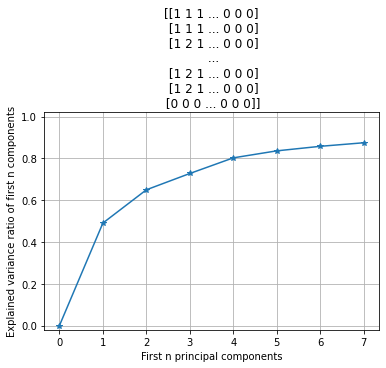

In [18]:
plot_pca_component_variance(explain, X_test.to_numpy(), y_test.to_numpy())

In [23]:
tree = DecisionTreeClassifier(max_features=6,max_depth=10, max_leaf_nodes=10)
m = tree.fit(X_train, y_train)
m.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.39371716, 0.        , 0.01365416, 0.        ,
       0.        , 0.34079608, 0.        , 0.0560089 , 0.        ,
       0.        , 0.        , 0.08217763, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.08406773, 0.00404803,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02553031, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [24]:
print(export_text(tree)) # [33, 28, 26, 36, 31, 61, 42]

|--- feature_26 <= 0.50
|   |--- class: 1
|--- feature_26 >  0.50
|   |--- feature_31 <= 0.50
|   |   |--- feature_43 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_43 >  0.50
|   |   |   |--- class: 2
|   |--- feature_31 >  0.50
|   |   |--- feature_37 <= 0.50
|   |   |   |--- feature_52 <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_52 >  0.50
|   |   |   |   |--- class: 2
|   |   |--- feature_37 >  0.50
|   |   |   |--- feature_33 <= 0.50
|   |   |   |   |--- class: 2
|   |   |   |--- feature_33 >  0.50
|   |   |   |   |--- feature_33 <= 2.50
|   |   |   |   |   |--- feature_28 <= 2.50
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- feature_28 >  2.50
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- feature_33 >  2.50
|   |   |   |   |   |--- feature_44 <= 1.00
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- feature_44 >  1.00
|   |   |   |   |   |   |--- class: 3



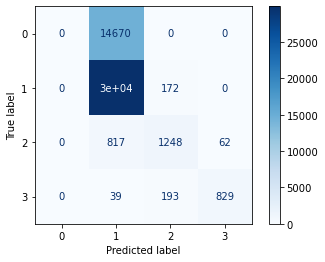

In [25]:
plot_confusion_matrix(tree, X, y, cmap=plt.cm.Blues)

In [26]:
[X_test.columns[i] for i in [33, 28, 26, 36, 31, 61, 42]]

['HESHF2', 'HESS3', 'HESS2', 'HESHF3', 'HESSM4', 'HESSH5', 'HESHM5']

In [27]:
kf = KFold(shuffle=True, n_splits=7)
np.mean([np.mean(cross_val_score(tree, X_test, y_test, cv=kf, scoring='accuracy')) for i in range(100)])

0.9247753838377457

In [29]:
summary = food.loc[:, id_cols + food_cols + geo_cols]
summary = summary.loc[summary['HRFS12M1'] > 0]

statuses = {-9: 'no response', -1: 'unknown', 1: 'secure', 2: 'insecure', 3: 'very_insecure'}
statuses_adult = {-9: 'no response', -1: 'unknown', 1: 'secure', 2: 'marginally_insecure', 3: 'insecure',
                  4: 'very_insecure'}
summary.loc[summary['HRFS12M1'] > 1, ['FIPS_COUNTY', 'HRFS12M1']].groupby('FIPS_COUNTY').size().sort_values()

FIPS_COUNTY
19103      1
27003      1
39057      1
51153      1
09015      1
        ... 
35001     75
32003     85
15003     87
04013    126
06037    240
Length: 235, dtype: int64

In [30]:
food['HRFS12M1'].unique()

array([ 1, -1,  3,  2, -9], dtype=int64)

In [31]:
fipses = counties['FIPS_COUNTY'].unique()
count = 0
u = list(summary.FIPS_COUNTY.unique())
found = [fips for fips in u if fips in fipses]
print(f"found {len(found)} out of {len(u)} counties")

found 280 out of 280 counties


In [34]:
insecure = summary.loc[summary.HRFS12M1 > 1]
insecure

,QSTNUM,HRFS12M1,HRFS12MC,HRFS12M8,GCFIP,GCTCO,FIPS_COUNTY
356,180,3,1,4,04,013,04013
357,180,3,1,4,04,013,04013
358,180,3,1,4,04,013,04013
359,180,3,1,4,04,013,04013
402,200,2,-1,3,04,025,04025
...,...,...,...,...,...,...,...
136640,68214,2,1,3,30,111,30111
136641,68214,2,1,3,30,111,30111
136642,68214,2,1,3,30,111,30111
136643,68214,2,1,3,30,111,30111


In [35]:
col_names = {'QSTNUM': "HOUSE_ID", 'HRFS12M1': 'FOOD_INSECURE_HOUSE', 'HRFS12MC': 'FOOD_INSECURE_CHILDREN',
             'HRFS12M8': 'FOOD_INSECURE_ADULTS'}
col_trans = {'HRFS12M1': statuses, 'HRFS12MC': statuses, 'HRFS12M8': statuses_adult}
c = insecure.loc[:]
for fc in food_cols:
    c[fc] = c[fc].apply(lambda f: col_trans[fc][f])
c = c.rename(columns=col_names)
c.drop(columns=['GCFIP', 'GCTCO'], inplace=True)
c = c.reset_index(drop=True)
c

,HOUSE_ID,FOOD_INSECURE_HOUSE,FOOD_INSECURE_CHILDREN,FOOD_INSECURE_ADULTS,FIPS_COUNTY
0,180,very_insecure,secure,very_insecure,04013
1,180,very_insecure,secure,very_insecure,04013
2,180,very_insecure,secure,very_insecure,04013
3,180,very_insecure,secure,very_insecure,04013
4,200,insecure,unknown,insecure,04025
...,...,...,...,...,...
3183,68214,insecure,secure,insecure,30111
3184,68214,insecure,secure,insecure,30111
3185,68214,insecure,secure,insecure,30111
3186,68214,insecure,secure,insecure,30111


In [36]:
t = pd.DataFrame(insecure.FIPS_COUNTY.unique(), columns=['FIPS_COUNTY'])
t

,FIPS_COUNTY
0,04013
1,04025
2,06019
3,06037
4,06053
...,...
230,12071
231,24025
232,36091
233,06061


In [38]:
s = c.loc[:]
# s.loc[:,['HOUSE_ID','FOOD_INSECURE_HOUSE','FOOD_INSECURE_CHILDREN','FOOD_INSECURE_ADULTS','FIPS_COUNTY']].groupby('HOUSE_ID')
s = s.drop_duplicates()
s

,HOUSE_ID,FOOD_INSECURE_HOUSE,FOOD_INSECURE_CHILDREN,FOOD_INSECURE_ADULTS,FIPS_COUNTY
0,180,very_insecure,secure,very_insecure,04013
4,200,insecure,unknown,insecure,04025
6,247,insecure,insecure,insecure,06019
14,268,very_insecure,unknown,very_insecure,06037
15,290,insecure,insecure,insecure,06037
...,...,...,...,...,...
3177,65393,insecure,unknown,insecure,36005
3178,65495,insecure,insecure,insecure,36119
3181,67339,insecure,unknown,insecure,12083
3183,68214,insecure,secure,insecure,30111


In [39]:
r = s.merge(counties).reset_index(drop=True)

r.to_csv('data/output/food_insecure_households_geocoded.csv', index=False, header=True, quoting=csv.QUOTE_NONNUMERIC)
r

,HOUSE_ID,FOOD_INSECURE_HOUSE,FOOD_INSECURE_CHILDREN,FOOD_INSECURE_ADULTS,FIPS_COUNTY,INTPTLAT,INTPTLONG
0,180,very_insecure,secure,very_insecure,04013,33.487395,-112.035529
1,1931,very_insecure,insecure,very_insecure,04013,33.487395,-112.035529
2,2349,insecure,secure,insecure,04013,33.487395,-112.035529
3,2353,very_insecure,unknown,very_insecure,04013,33.487395,-112.035529
4,5927,insecure,unknown,insecure,04013,33.487395,-112.035529
...,...,...,...,...,...,...,...
1284,55058,very_insecure,insecure,very_insecure,12071,26.569076,-81.857869
1285,55266,insecure,secure,very_insecure,24025,39.522326,-76.296491
1286,55497,insecure,unknown,insecure,36091,43.028347,-73.794118
1287,59184,very_insecure,insecure,insecure,06061,38.870385,-121.110806


In [48]:
# arr = r['INTPTLONG','INTPTLAT']
# arr
r = r.reset_index(drop=True)
r['LONG'] = r['INTPTLONG']
r['LAT'] = r['INTPTLAT']
r = r.rename(columns={'FIPS_COUNTY':'FIPS_CODE'})
insecure_locations = r.loc[:][['FIPS_CODE','INTPTLAT', 'INTPTLONG']]
insecure_locations['NODE_TYPE'] = 'insecure'
insecure_locations['INTPTLAT'] = insecure_locations['INTPTLAT'].astype(np.float64)
insecure_locations['INTPTLONG'] = insecure_locations['INTPTLONG'].astype(np.float64)
insecure_locations = insecure_locations.rename(columns={'INTPTLAT':'LAT', 'INTPTLONG': 'LONG'})
insecure_locations

,FIPS_CODE,LAT,LONG,NODE_TYPE
0,04013,33.487395,-112.035529,insecure
1,04013,33.487395,-112.035529,insecure
2,04013,33.487395,-112.035529,insecure
3,04013,33.487395,-112.035529,insecure
4,04013,33.487395,-112.035529,insecure
...,...,...,...,...
1284,12071,26.569076,-81.857869,insecure
1285,24025,39.522326,-76.296491,insecure
1286,36091,43.028347,-73.794118,insecure
1287,06061,38.870385,-121.110806,insecure


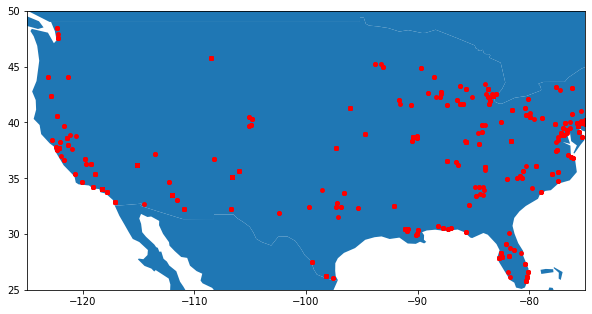

In [49]:
plotz = r.loc[~r['FOOD_INSECURE_HOUSE'].isin(['unknown', 'secure'])]
geometry = [Point(xy) for xy in zip(plotz['LONG'], plotz['LAT'])]
gdf = GeoDataFrame(plotz, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
wax = world.plot(figsize=(10, 6))
wax.set_xlim(-125, -75)
wax.set_ylim(25, 50)
dink = gdf.plot(ax=wax, marker='o', color='red', markersize=15);

In [50]:
deserts = pd.read_csv('data/food_access_research_atlas.csv', dtype={'CensusTract': np.str})
deserts.drop(['TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN',
              'TractOMultir', 'TractHispanic'], inplace=True, axis=1)
deserts['FIPS_CODE'] = deserts['CensusTract'].str.slice(0, 5)
deserts.head()

<ipython-input-50-d0798a164612>:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  deserts = pd.read_csv('data/food_access_research_atlas.csv', dtype={'CensusTract': np.str})


,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractHUNV,TractSNAP,FIPS_CODE
0,01001020100,Alabama,Autauga,1,1912,693,0,0,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,448,507,26,112,01001
1,01001020200,Alabama,Autauga,1,2170,743,0,181,0.083410,0,...,0.0,0.0,0.0,0.0,0.0,763,606,87,202,01001
2,01001020300,Alabama,Autauga,1,3373,1256,0,0,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,1578,894,108,120,01001
3,01001020400,Alabama,Autauga,1,4386,1722,0,0,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,1241,1015,19,82,01001
4,01001020500,Alabama,Autauga,1,10766,4082,0,181,0.016812,0,...,0.0,0.0,0.0,0.0,0.0,2692,3162,198,488,01001


In [51]:
deserts.groupby('FIPS_CODE').agg('sum')
unfound = [n for n in list(deserts['FIPS_CODE'].unique()) if n not in fipses]
found_deserts = deserts.loc[~deserts.FIPS_CODE.isin(unfound)]
len(found_deserts)

72856

In [52]:
located_deserts = found_deserts.merge(counties, left_on='FIPS_CODE', right_on='FIPS_COUNTY').reset_index()
located_deserts = located_deserts.rename(columns={'INTPTLAT':'LAT', 'INTPTLONG': 'LONG'})
located_deserts

,index,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,...,lasnap20,lasnap20share,TractLOWI,TractKids,TractHUNV,TractSNAP,FIPS_CODE,FIPS_COUNTY,LAT,LONG
0,0,01001020100,Alabama,Autauga,1,1912,693,0,0,0.000000,...,0.000000,0.000000,448,507,26,112,01001,01001,32.501335,-86.500472
1,1,01001020200,Alabama,Autauga,1,2170,743,0,181,0.083410,...,0.000000,0.000000,763,606,87,202,01001,01001,32.501335,-86.500472
2,2,01001020300,Alabama,Autauga,1,3373,1256,0,0,0.000000,...,0.000000,0.000000,1578,894,108,120,01001,01001,32.501335,-86.500472
3,3,01001020400,Alabama,Autauga,1,4386,1722,0,0,0.000000,...,0.000000,0.000000,1241,1015,19,82,01001,01001,32.501335,-86.500472
4,4,01001020500,Alabama,Autauga,1,10766,4082,0,181,0.016812,...,0.000000,0.000000,2692,3162,198,488,01001,01001,32.501335,-86.500472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72851,72851,56043000200,Wyoming,Washakie,0,3326,1317,0,57,0.017138,...,29.946541,0.022738,1013,884,56,116,56043,56043,43.973990,-107.858727
72852,72852,56043000301,Wyoming,Washakie,1,2665,1154,0,10,0.003752,...,0.000000,0.000000,1214,674,114,124,56043,56043,43.973990,-107.858727
72853,72853,56043000302,Wyoming,Washakie,1,2542,1021,0,73,0.028717,...,0.000000,0.000000,742,614,82,97,56043,56043,43.973990,-107.858727
72854,72854,56045951100,Wyoming,Weston,0,3314,1322,0,252,0.076041,...,2.861406,0.002164,671,655,108,50,56045,56045,43.852931,-104.407266


In [53]:
located_deserts['TOTAL_LOW_ACCESS_POP'] = located_deserts[['LAPOP1_10', 'LAPOP05_10', 'LAPOP1_20', 'LALOWI1_10', 'LALOWI05_10', 'LALOWI1_20']].sum(axis=1).astype(np.int)
located_deserts['TOTAL_LOW_ACCESS_POP']

<ipython-input-53-e5d79aa419bc>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  located_deserts['TOTAL_LOW_ACCESS_POP'] = located_deserts[['LAPOP1_10', 'LAPOP05_10', 'LAPOP1_20', 'LALOWI1_10', 'LALOWI05_10', 'LALOWI1_20']].sum(axis=1).astype(np.int)


0         5503
1         3142
2         8343
3         8265
4        16224
         ...  
72851     3394
72852     1112
72853     1646
72854     2242
72855     7268
Name: TOTAL_LOW_ACCESS_POP, Length: 72856, dtype: int32

<AxesSubplot:>

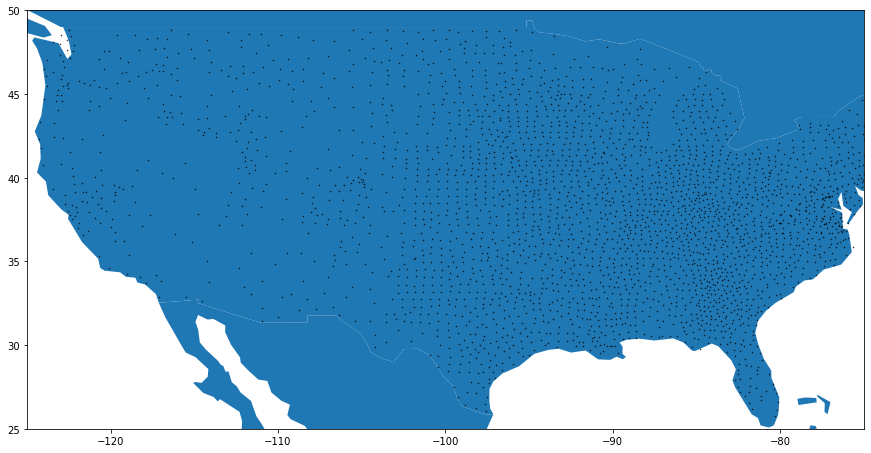

In [56]:
reduced_deserts = located_deserts.loc[:,['FIPS_CODE', 'LONG', 'LAT']].groupby('FIPS_CODE').mean()
reduced_deserts['NUM_INST'] = located_deserts.loc[:,['FIPS_CODE', 'TOTAL_LOW_ACCESS_POP']].groupby('FIPS_CODE').mean()
reduced_deserts['NODE_TYPE'] = 'desert'
desert_points = [Point(xy) for xy in reduced_deserts[['LONG', 'LAT']].to_numpy().tolist()]
desert_gdf = GeoDataFrame(geometry=desert_points)
clust_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
dax = clust_world.plot(figsize=(15, 9))
dax.set_xlim(-125, -75)
dax.set_ylim(25, 50)

desert_gdf.plot(ax=dax, color='k', marker='o', alpha=0.8, markersize=0.3 )

In [57]:
insecure_fips = insecure_locations.groupby('FIPS_CODE').mean()
insecure_fips['NUM_INST'] = insecure_locations.groupby('FIPS_CODE')['NODE_TYPE'].count()
insecure_fips['NODE_TYPE'] = 'insecure'
insecure_fips

,LAT,LONG,NUM_INST,NODE_TYPE
FIPS_CODE,,,,
01003,30.521478,-87.749095,6,insecure
01081,32.595610,-85.364746,3,insecure
01097,30.681157,-88.156268,3,insecure
04013,33.487395,-112.035529,52,insecure
04019,32.215772,-110.960846,10,insecure
...,...,...,...,...
55059,42.575997,-87.903374,1,insecure
55073,44.914599,-89.720889,3,insecure
55101,42.736791,-87.908024,4,insecure


In [58]:
combined_locations = pd.concat([insecure_fips, reduced_deserts]).reset_index()
combined_locations

,FIPS_CODE,LAT,LONG,NUM_INST,NODE_TYPE
0,01003,30.521478,-87.749095,6.000000,insecure
1,01081,32.595610,-85.364746,3.000000,insecure
2,01097,30.681157,-88.156268,3.000000,insecure
3,04013,33.487395,-112.035529,52.000000,insecure
4,04019,32.215772,-110.960846,10.000000,insecure
...,...,...,...,...,...
3369,56037,41.576203,-109.288254,3505.583333,desert
3370,56039,43.619624,-110.733272,3234.500000,desert
3371,56041,41.294645,-110.722364,723.666667,desert
3372,56043,43.973990,-107.858727,2050.666667,desert


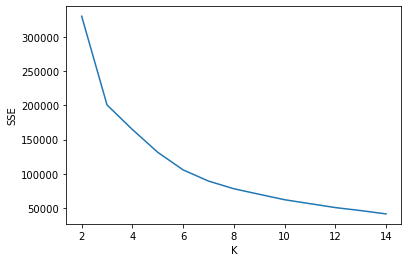

In [59]:
# from https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion
def best_k(points, max_k: int = 15):
    return {k: KMeans(n_clusters=k).fit(points).inertia_ for k in range(2, max_k)}
errs = best_k(np.array(combined_locations[['LAT', 'LONG']].to_numpy()))
plt.figure()
plt.plot(list(errs.keys()), list(errs.values()))
plt.xlabel("K")
plt.ylabel("SSE")
plt.show() # shows '6' is optimal

#### The above shows that the optimal k is 6 or 7 - I'll choose 7 for the following


In [60]:
km = KMeans(n_clusters=25).fit(combined_locations[['LONG', 'LAT']].to_numpy())
centroids = km.cluster_centers_

Now that we have the clusters, we need to calculate the size they should be -- this should be a simple 'count' of instances, but we have to account for the _types_ of things, as well.  perhaps heat like heatmap?

In [61]:
centers = pd.DataFrame(centroids, columns=['LONG', 'LAT'])
combined_locations['CLUSTER_ID'] = km.predict(combined_locations[['LONG', 'LAT']])
combined_locations

,FIPS_CODE,LAT,LONG,NUM_INST,NODE_TYPE,CLUSTER_ID
0,01003,30.521478,-87.749095,6.000000,insecure,18
1,01081,32.595610,-85.364746,3.000000,insecure,7
2,01097,30.681157,-88.156268,3.000000,insecure,18
3,04013,33.487395,-112.035529,52.000000,insecure,19
4,04019,32.215772,-110.960846,10.000000,insecure,19
...,...,...,...,...,...,...
3369,56037,41.576203,-109.288254,3505.583333,desert,19
3370,56039,43.619624,-110.733272,3234.500000,desert,24
3371,56041,41.294645,-110.722364,723.666667,desert,24
3372,56043,43.973990,-107.858727,2050.666667,desert,0


In [62]:
centroid_counts = combined_locations.loc[combined_locations.NODE_TYPE == 'desert'].groupby('CLUSTER_ID').mean().loc[:, ['NUM_INST']].reset_index()
centroid_counts['NUM_INST'] = centroid_counts['NUM_INST'].astype(np.int)
# centroid_counts = centroid_counts.sort_values('NUM_INST', ascending=False)
centroid_counts['LONG'] = centroids[:,0]
centroid_counts['LAT'] = centroids[:,1]
centroid_counts = centroid_counts.sort_values('NUM_INST', ascending=False)
centroid_counts

<ipython-input-62-678617668977>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  centroid_counts['NUM_INST'] = centroid_counts['NUM_INST'].astype(np.int)


,CLUSTER_ID,NUM_INST,LONG,LAT
4,4,7739,-154.388799,62.042822
19,19,6146,-109.219134,36.278849
15,15,5350,-82.239759,29.422668
21,21,5325,-97.163991,30.322902
3,3,5169,-121.700261,45.767856
22,22,5005,-120.167870,37.683804
10,10,4923,-157.405444,21.085813
9,9,4559,-101.026152,33.756583
24,24,4528,-113.699806,44.849257
2,2,4468,-94.537578,35.767647


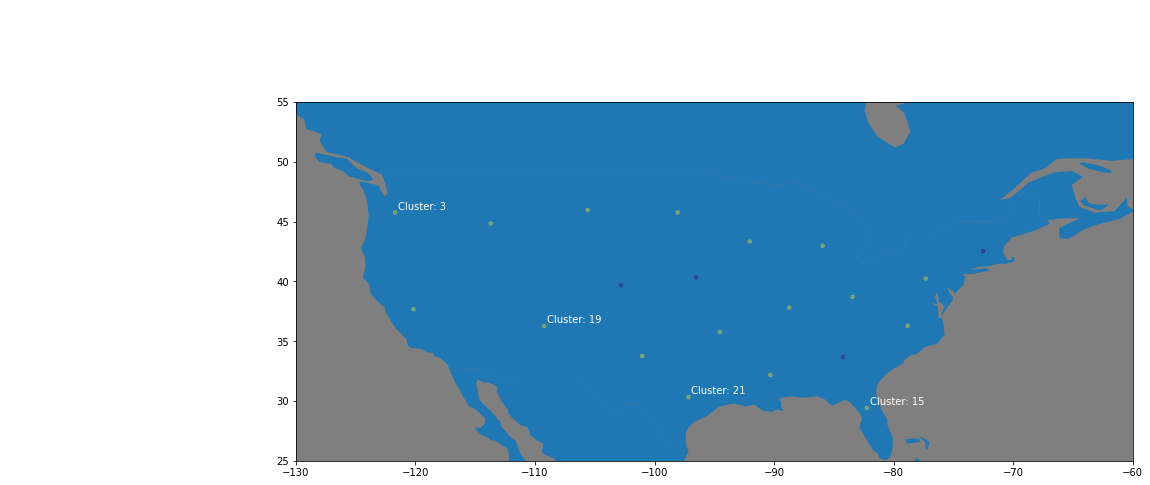

In [63]:
clust_geo = [Point(xy) for xy in centroids.tolist()]
clust_gdf = GeoDataFrame(centroids, geometry=clust_geo)

cax = clust_world.plot(figsize=(15, 9))
for row in [l for _, l in centroid_counts.iterrows()][:5]:
    cax.annotate(f"Cluster: {row.CLUSTER_ID.astype(np.int32)}", xy=(row.LONG, row.LAT), xytext=(3, 3), textcoords="offset points", color='w')
cax.set_xlim(-130, -60)
cax.set_ylim(25, 55)
cax.set_facecolor('tab:grey')

clusterplot = clust_gdf.plot(ax=cax, marker='o', c=y, alpha=0.33333, markersize=13, legend=True);

In [70]:
combined_locations.sort_values('NUM_INST', ascending=False)
combined_locations

,FIPS_CODE,LAT,LONG,NUM_INST,NODE_TYPE,CLUSTER_ID
0,01003,30.521478,-87.749095,6.000000,insecure,18
1,01081,32.595610,-85.364746,3.000000,insecure,7
2,01097,30.681157,-88.156268,3.000000,insecure,18
3,04013,33.487395,-112.035529,52.000000,insecure,19
4,04019,32.215772,-110.960846,10.000000,insecure,19
...,...,...,...,...,...,...
3369,56037,41.576203,-109.288254,3505.583333,desert,19
3370,56039,43.619624,-110.733272,3234.500000,desert,24
3371,56041,41.294645,-110.722364,723.666667,desert,24
3372,56043,43.973990,-107.858727,2050.666667,desert,0


In [71]:
combined_locations.loc[combined_locations.CLUSTER_ID == 17, 'NUM_INST'].sum()

870476.0358147875

In [77]:
cluster17_fips = list(combined_locations.loc[combined_locations.CLUSTER_ID == 17]['FIPS_CODE'].unique())
cluster17_fips

['37001',
 '37067',
 '37119',
 '37133',
 '37147',
 '37159',
 '37179',
 '37191',
 '45041',
 '45051',
 '45091',
 '51041',
 '51700',
 '51710',
 '51760',
 '51810',
 '37003',
 '37005',
 '37007',
 '37009',
 '37013',
 '37015',
 '37017',
 '37019',
 '37023',
 '37025',
 '37027',
 '37029',
 '37031',
 '37033',
 '37035',
 '37037',
 '37041',
 '37045',
 '37047',
 '37049',
 '37051',
 '37053',
 '37055',
 '37057',
 '37059',
 '37061',
 '37063',
 '37065',
 '37069',
 '37071',
 '37073',
 '37077',
 '37079',
 '37081',
 '37083',
 '37085',
 '37091',
 '37093',
 '37095',
 '37097',
 '37101',
 '37103',
 '37105',
 '37107',
 '37109',
 '37117',
 '37123',
 '37125',
 '37127',
 '37129',
 '37131',
 '37135',
 '37137',
 '37139',
 '37141',
 '37143',
 '37145',
 '37151',
 '37153',
 '37155',
 '37157',
 '37163',
 '37165',
 '37167',
 '37169',
 '37171',
 '37177',
 '37181',
 '37183',
 '37185',
 '37187',
 '37189',
 '37193',
 '37195',
 '37197',
 '45015',
 '45017',
 '45019',
 '45023',
 '45025',
 '45027',
 '45031',
 '45033',
 '45035',


### Calculating the potential revenue from these sources

https://cias.wisc.edu/2001/01/01/csa-more-for-your-money-than-fresh-vegetables/

lists the range as $306-415 per 22-week period for the CSAs.  that mean is $360, which, when annualized is $851.
...indicating that a gross revenue of $851 is approximately one subscriber per year.

In [ ]:
deserts.columns.to_list()
deserts.loc[deserts['FIPS_CODE'].isin(cluster17_fips)]['TractSNAP'].drop_duplicates().sum()
